In [4]:
import tensorflow as tf
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt

In [5]:
#Images and label from link below
#https://www.kaggle.com/puneet6060/intel-image-classification
#Create a list of all image paths with a matching label list
base_path = 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/'
dir_paths = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
raw_image_paths = []

filePathAdder = lambda x : base_path + folder + '/' + x

#Get true file paths for every image
for folder in dir_paths:
    raw_image_paths.append(list(map(filePathAdder, listdir(base_path + folder + '/'))))
    
raw_image_paths = np.array(raw_image_paths)

print(raw_image_paths[0][:10])
for i in range(0, 6):
    print(np.shape(raw_image_paths[i]))

['A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/0.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10006.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/1001.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10014.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10018.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10029.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10032.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-Image-Classification/Images + Labels/buildings/10056.jpg', 'A:/Users/Adam/Desktop/Programs/Machine Learning/Project-3-I

In [6]:
#Make the database rectangular by creating an image and a label column
image_paths = []
labels = []

for i in range(0, 6):
    image_paths = image_paths + raw_image_paths[i]
    labels = labels + [i for k in range(len(raw_image_paths[i]))]
    print(str(i) + ' = ' + dir_paths[i])

print(len(image_paths))
print(len(labels))

0 = buildings
1 = forest
2 = glacier
3 = mountain
4 = sea
5 = street
17034
17034


In [7]:
#Take the image paths and labels and create an iterator containing the labels and resized images from the paths
epoch_size = len(image_paths)
out_shape = tf.constant([150, 150])
batch_size = 25
shuffle_batch_size = 1000

image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
labels = tf.convert_to_tensor(labels)


dataset = tf.data.Dataset.from_tensor_slices((image_paths,  labels))

dataset = dataset.repeat().shuffle(epoch_size)

#Map each path to an image and resizing it to a single set size
def map_fn(path, label):
    # path/label represent values for a single example
    image = tf.image.decode_jpeg(tf.io.read_file(path))

    # some mapping to constant size - be careful with distorting aspec ratios
    image = tf.image.resize(image, size=out_shape)
    # color normalization - just an example
    image = tf.compat.v1.to_float(image) * (2. / 255) - 1
    return image, label

# num_parallel_calls > 1 induces intra-batch shuffling
dataset = dataset.map(map_fn, num_parallel_calls=8)
#dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(shuffle_batch_size)
# try one of the following
dataset = dataset.prefetch(1)
# dataset = dataset.apply(
#            tf.contrib.data.prefetch_to_device('/gpu:0'))

#image_batch, label_batch = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()

Instructions for updating:
Use `tf.cast` instead.


In [23]:
#Split the data into train, validation, and test datasets
trainLen, valLen, testLen = 16000, 500, 535
train = dataset.take(trainLen)
validation = dataset.take(valLen)
test = dataset.take(testLen)

In [24]:
#Batch each of the datasets
train_batches = train.shuffle(shuffle_batch_size).batch(batch_size)
validation_batches = validation.batch(batch_size)
test_batches = test.batch(batch_size)

In [25]:
for image_batch, label_batch in train_batches.take(1):
   pass

In [26]:
print(image_batch.shape)
print(label_batch.shape)

(25, 150, 150, 3)
(25,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'tf.Tensor(1, shape=(), dtype=int32)')

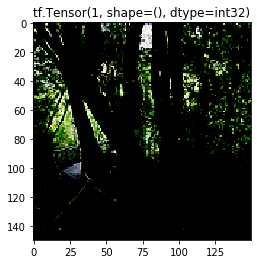

In [27]:
#Show an image and its label
plt.figure()
plt.imshow(image_batch[3])
plt.title(str(label_batch[3]))

In [28]:
#Require the input shape so the model can properly take the images
IMG_SHAPE = (150, 150, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

A:\Users\Adama\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [29]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(25, 5, 5, 1280)


In [30]:
#Freeze the covnet model
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(25, 1280)


In [32]:
#hidden_layer = tf.keras.layers.Dense(512, activation='relu', name='hidden_layer')
prediction_layer = tf.keras.layers.Dense(len(dir_paths), activation='sigmoid', name='output')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(25, 6)


In [33]:
#Combine the pretrained covnet with the prediction layer
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  #hidden_layer,
  prediction_layer
])

In [34]:
# Create a checkpoint callback for the weights
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [35]:
#Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
initial_epochs = 10
#Train the model with the train batches
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[checkpoint_callback])

Train for 640 steps, validate for 20 steps
Epoch 1/5
640/640 [==============================] - 804s 1s/step - loss: 1.1049 - accuracy: 0.6022 - val_loss: 0.6422 - val_accuracy: 0.7600
Epoch 2/5
640/640 [==============================] - 774s 1s/step - loss: 0.5817 - accuracy: 0.8083 - val_loss: 0.4362 - val_accuracy: 0.8480
Epoch 3/5
640/640 [==============================] - 751s 1s/step - loss: 0.4835 - accuracy: 0.8334 - val_loss: 0.4318 - val_accuracy: 0.8220
Epoch 4/5
640/640 [==============================] - 663s 1s/step - loss: 0.4556 - accuracy: 0.8381 - val_loss: 0.3708 - val_accuracy: 0.8640
Epoch 5/5
640/640 [==============================] - 662s 1s/step - loss: 0.4275 - accuracy: 0.8476 - val_loss: 0.3245 - val_accuracy: 0.8880


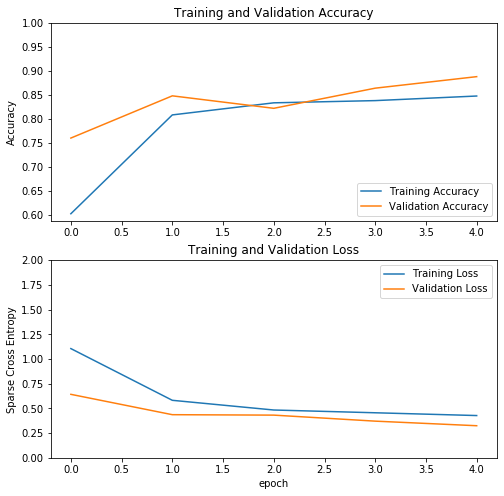

In [40]:
#Plot the accuracy and loss over the epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
#Use the model against the test data
lossTest,accuracyTest = model.evaluate(test_batches, steps = validation_steps)
print("Test loss: {:.2f}".format(lossTest))
print("Test accuracy: {:.2f}".format(accuracyTest))

20/20 [==============================] - 4s 187ms/step - loss: 0.4620 - accuracy: 0.8460
Test loss: 0.46
Test accuracy: 0.85
